# Weather file - visulization
- Main task: visualizing weather station locations, yield, & climatology of sites
- Main input:
    - weather station list & detail
    - USDA NASS maize yield data
    - compiled weater data (temp, rh, precip, solrad)
- Main output: 
    - weather stations map
    - yield map & station locations
    - climatology: temp & precip

In [1]:
import numpy as np
import pandas as pd
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import glob
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import xarray as xr
import datetime
import seaborn as sns

from scipy.stats.stats import pearsonr
from palettable.colorbrewer.sequential import OrRd_6
from palettable.colorbrewer.sequential import YlGn_9
from palettable.colorbrewer.sequential import YlGnBu_8
from palettable.colorbrewer.sequential import RdPu_5
from palettable.colorbrewer.sequential import Purples_9

### 1. Overall site-year coverage

Text(0.5, 0, 'stations')

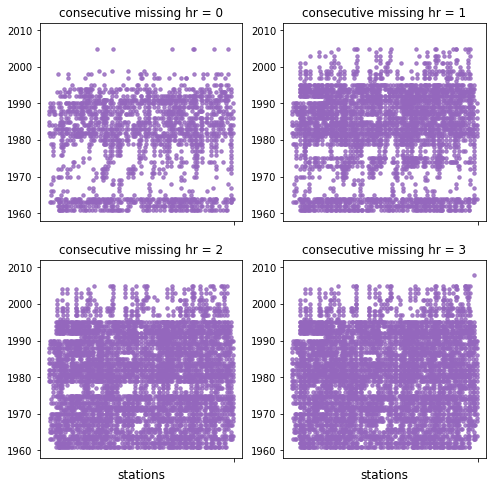

In [15]:
siteyear_ctr0 = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/siteyears_crithr0.csv',
                           dtype={'site': object}, usecols=[1,2])
siteyear_ctr1 = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/siteyears_crithr1.csv',
                           dtype={'site': object}, usecols=[1,2])
siteyear_ctr2 = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/siteyears_crithr2.csv',
                           dtype={'site': object}, usecols=[1,2]) 
siteyear_ctr3 = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/siteyears_crithr3.csv',
                           dtype={'site': object}, usecols=[1,2]) 

fig = plt.figure(figsize=(8,8))

ax1 = fig.add_subplot(2,2,1)
ax1.scatter(siteyear_ctr0.site, siteyear_ctr0.year, alpha=0.8, color='tab:purple', s=12)
ax1.set_ylim(1958, 2012)
ax1.set_xticks('')
ax1.set_title('consecutive missing hr = 0')

ax2 = fig.add_subplot(2,2,2)
ax2.scatter(siteyear_ctr1.site, siteyear_ctr1.year, alpha=0.8, color='tab:purple', s=12)
ax2.set_ylim(1958, 2012)
ax2.set_xticks('')
ax2.set_title('consecutive missing hr = 1')

ax3 = fig.add_subplot(2,2,3)
ax3.scatter(siteyear_ctr2.site, siteyear_ctr2.year, alpha=0.8, color='tab:purple', s=12)
ax3.set_ylim(1958, 2012)
ax3.set_xticks('')
ax3.set_title('consecutive missing hr = 2')
ax3.set_xlabel('stations', fontsize=12)

ax4 = fig.add_subplot(2,2,4)
ax4.scatter(siteyear_ctr3.site, siteyear_ctr3.year, alpha=0.8, color='tab:purple', s=12)
ax4.set_ylim(1958, 2012)
ax4.set_xticks('')
ax4.set_title('consecutive missing hr = 3')
ax4.set_xlabel('stations', fontsize=12)

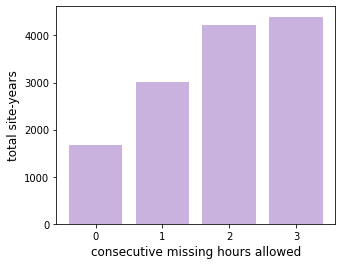

In [16]:
siteyears_ctr0 = siteyear_ctr0.shape[0]
siteyears_ctr1 = siteyear_ctr1.shape[0]
siteyears_ctr2 = siteyear_ctr2.shape[0]
siteyears_ctr3 = siteyear_ctr3.shape[0]

fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot(1,1,1)
ctrhr = [0,1,2,3]
siteyears = [siteyears_ctr0, siteyears_ctr1, siteyears_ctr2, siteyears_ctr3]
ax.bar(ctrhr, siteyears, alpha=0.5, color='tab:purple')
ax.set_xlabel('consecutive missing hours allowed', fontsize=12)
ax.set_ylabel('total site-years', fontsize=12)
ax.set_xticks([0,1,2,3])

### 2. Stations map - critical hour: 2

In [17]:
# read in station & site-year info
df_site_nyears = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/site_nyears_crithr2.csv', index_col=0)
df_stations_9110 = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/stations_info_9110.csv', usecols=[0,1,3,4,8,9,10])
df_sites_info = df_stations_9110[df_stations_9110.USAF.isin(df_site_nyears.site)]
df_sites_info.columns = ['site', 'class', 'station', 'state', 'tzone', 'lat', 'lon']

# merge site info & site-years info
df_sites_info = pd.merge(df_sites_info, df_site_nyears, on='site')

# drop stations from Alaska, Guam, Hawaii & Puerto Rico
df_sites_info = df_sites_info[(df_sites_info.state != 'AK') & (df_sites_info.state != 'GU') & 
                              (df_sites_info.state != 'HI')& (df_sites_info.state != 'PR')]

# final station list
df_sites_info.reset_index(inplace=True, drop=True)
df_sites_info.head()

,site,class,station,state,tzone,lat,lon,years
0,722010,1,KEY WEST INTL ARPT,FL,-5,24.550,-81.750,25
1,722020,1,MIAMI INTL AP,FL,-5,25.817,-80.300,29
2,722030,1,WEST PALM BEACH INTL ARPT,FL,-5,26.683,-80.100,19
3,722050,1,ORLANDO INTL ARPT,FL,-5,28.433,-81.333,19
4,722056,1,DAYTONA BEACH INTL AP,FL,-5,29.183,-81.067,19


In [20]:
state = pd.read_csv('/home/disk/eos3/aswann/Shared/Data/irrigated_area/stateID.txt', header=None, sep='\s+')
county = pd.read_csv('/home/disk/eos3/aswann/Shared/Data/irrigated_area/countyID.txt', header=None, sep='\s+')
lat = pd.read_csv('/home/disk/eos3/aswann/Shared/Data/irrigated_area/lat_county.txt', header=None, sep='\s+')
lon = pd.read_csv('/home/disk/eos3/aswann/Shared/Data/irrigated_area/lon_county.txt', header=None, sep='\s+')
irri = pd.read_csv('/home/disk/eos3/aswann/Shared/Data/irrigated_area/irr_area_acres.txt', header=None, sep='\s+')
area = pd.read_csv('/home/disk/eos3/aswann/Shared/Data/irrigated_area/crop_area_acres.txt', header=None, sep='\s+')
state = state.iloc[0,:]
county = county.iloc[0,:]
lat = lat.iloc[0,:]
lon = lon.iloc[0,:]

# raw data includes data from 4 censuses that show data of 1997, 2002, 2007 & 2012
# we average data from all 4 censuses 
irri = irri.mean(axis=1)
area = area.mean(axis=1)
df_obs = pd.DataFrame({'state': state, 'county': county, 'lat': lat, 'lon': lon, 
                       'irri_area': irri, 'crop_area': area, 'perct_irri': irri/area*100})
df_obs.head()

,state,county,lat,lon,irri_area,crop_area,perct_irri
0,1.0,1.0,32.430976,-86.714727,973.500000,46089.75,2.112183
1,1.0,3.0,30.569698,-87.688916,9337.750000,109721.50,8.510410
2,1.0,5.0,31.907512,-85.306271,2850.000000,57627.75,4.945534
3,1.0,7.0,33.069184,-87.075724,83.333333,13352.25,0.624115
4,1.0,9.0,34.021667,-86.653387,532.750000,56643.25,0.940536


In [ ]:
# Reading in state & county id
state_id = pd.read_csv("/home/disk/eos8/ach315/data/NASS_cropdata/stateID.txt", sep="\s+", header=None)
state_id = state_id.transpose()
state_id.columns = ["state_id"]
county_id = pd.read_csv("/home/disk/eos8/ach315/data/NASS_cropdata/countyID.txt", sep="\s+", header=None)
county_id = county_id.transpose()
county_id.columns = ["county_id"]

# Reading in lat & lon information
lat_county = pd.read_csv("/home/disk/eos8/ach315/data/NASS_cropdata/lat_county.txt", sep="\s+", header=None)
lat_county = lat_county.transpose()
lat_county.columns = ["lat"]
lon_county = pd.read_csv("/home/disk/eos8/ach315/data/NASS_cropdata/lon_county.txt", sep="\s+", header=None)
lon_county = lon_county.transpose()
lon_county.columns = ["lon"]

# Reading in maize yield
cornyield = pd.read_csv("/home/disk/eos8/ach315/data/NASS_cropdata/corn_yield.txt", sep="\s+", header=None)
years = np.arange(1910, 2015)
cornyield.columns = years

# Reading in maize area
cornarea = pd.read_csv("/home/disk/eos8/ach315/data/NASS_cropdata/corn_area.txt", sep="\s+", header=None)
years = np.arange(1910, 2015)
cornarea.columns = years
cornarea = cornarea.melt(var_name='year', value_name='area')
cornarea = cornarea.drop(['year'], axis=1)

# concatinating all information and melting dataframe
df = pd.concat([state_id, county_id, lat_county, lon_county, cornyield], axis=1)
df = pd.melt(df, id_vars=['state_id', 'county_id', 'lat', 'lon'], value_name='yield', var_name="year")
df = pd.concat([df, cornarea], axis=1)
print(df.shape)

In [21]:
sites = df_sites_info.site
areas = []
perct_irris = []

for site in sites:
    lat = float(df_sites_info[df_sites_info.site == site].lat)
    lon = float(df_sites_info[df_sites_info.site == site].lon)
    dist = list(enumerate(np.sqrt((lat - df_obs.lat)**2 + (lon - (df_obs.lon))**2)))
    df_dist = pd.DataFrame(dist, columns=['rownum', 'distance'])
    row = list(df_dist.nsmallest(5, 'distance').rownum) # select the five nearest locations and average for
                                                        # cropping area & irrigation percentage
    area = df_obs.iloc[row].crop_area.mean()
    perct_irri = df_obs.iloc[row].perct_irri.mean()
    areas.append(area)
    perct_irris.append(perct_irri)

# add planting area & irrigation info for filtering purposes
df_filter = pd.DataFrame({'area': areas, 'perct_irri': perct_irris})
df_summary = pd.concat([df_sites_info, df_filter], axis=1)
df_summary.head()

,site,class,station,state,tzone,lat,lon,years,area,perct_irri
0,722010,1,KEY WEST INTL ARPT,FL,-5,24.550,-81.750,25,84670.90,60.802507
1,722020,1,MIAMI INTL AP,FL,-5,25.817,-80.300,29,160227.65,62.002065
2,722030,1,WEST PALM BEACH INTL ARPT,FL,-5,26.683,-80.100,19,145225.95,78.435473
3,722050,1,ORLANDO INTL ARPT,FL,-5,28.433,-81.333,19,59312.40,55.098924
4,722056,1,DAYTONA BEACH INTL AP,FL,-5,29.183,-81.067,19,23625.30,50.088347


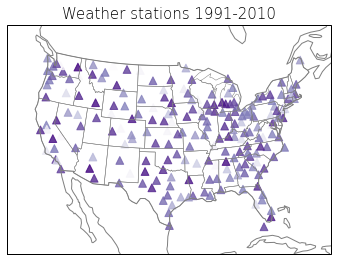

In [212]:
# creating map with weather station sites only
from palettable.colorbrewer.sequential import Purples_9

# sites not filtered
fig = plt.figure(figsize=(5,4))
ax1 = fig.add_subplot(1,1,1, projection=ccrs.AlbersEqualArea(
                          central_latitude=39.5, central_longitude=-98.35))
ax1.set_extent([-123, -72, 19, 53])
ax1.scatter(df_summary.lon, df_summary.lat, transform=ccrs.PlateCarree(), 
            s=60, marker='^',
            c=df_summary.years, cmap=Purples_9.mpl_colormap, alpha=0.8)
ax1.add_feature(cfeature.BORDERS, edgecolor='grey')
ax1.add_feature(cfeature.COASTLINE, edgecolor='grey')
ax1.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)
ax1.set_title('Weather stations 1991-2010', fontweight='light', fontsize=15)

fig.subplots_adjust(left=0.05, bottom=0, right=0.95, top=1)

### 3. Filtering based on planting area & irrigation
Planting area & irrigation information from 4 census data of 1997, 2002, 2007, & 2012

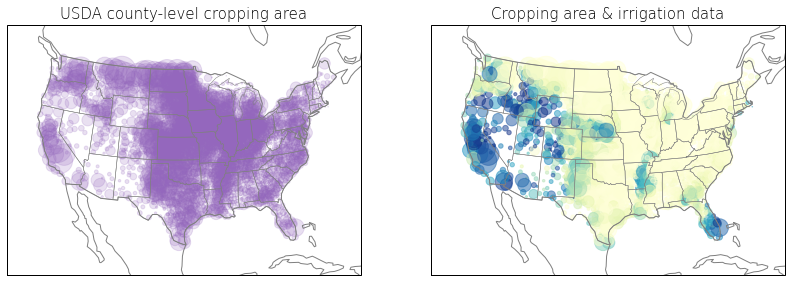

In [23]:
# creating map with weather station sites only
from palettable.colorbrewer.sequential import Purples_9

fig = plt.figure(figsize=(12,10))
ax1 = fig.add_subplot(1,2,1, projection=ccrs.AlbersEqualArea(
                         central_latitude=39.5, central_longitude=-98.35))
ax1.set_extent([-123, -72, 19, 53])
ax1.scatter(df_obs.lon.astype(float), df_obs.lat.astype(float), 
           transform=ccrs.PlateCarree(), s=df_obs.crop_area/1500, c='tab:purple', alpha=0.2)

ax1.add_feature(cfeature.BORDERS, edgecolor='grey')
ax1.add_feature(cfeature.COASTLINE, edgecolor='grey')
ax1.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)
ax1.set_title('USDA county-level cropping area', fontweight='light', fontsize=15)

ax2 = fig.add_subplot(1,2,2, projection=ccrs.AlbersEqualArea(
                        central_latitude=39.5, central_longitude=-98.35))
ax2.set_extent([-123, -72, 19, 53])
ax2.scatter(df_obs.lon, df_obs.lat, transform=ccrs.PlateCarree(), 
           c=df_obs.perct_irri*0.1, vmin=0, vmax=10, s=df_obs.crop_area/1500,
           cmap=YlGnBu_8.mpl_colormap, alpha=0.5)

ax2.add_feature(cfeature.BORDERS, edgecolor='grey')
ax2.add_feature(cfeature.COASTLINE, edgecolor='grey')
ax2.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)
ax2.set_title('Cropping area & irrigation data', fontweight='light', fontsize=15)
fig.subplots_adjust(left=0.05, bottom=0, right=0.95, top=1)

fig.subplots_adjust(left=0.05, bottom=0, right=0.95, top=1)

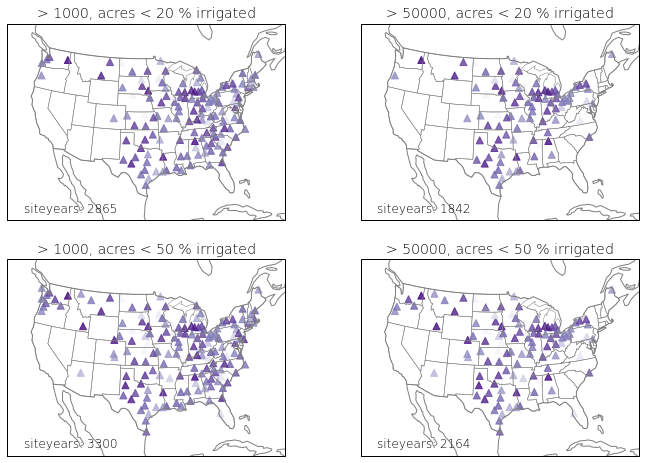

In [24]:
area = [1000, 50000, 1000, 50000]
irri = [20, 20, 50, 50]

# sites not filtered
fig = plt.figure(figsize=(10,6))

for i in np.arange(1,5):
    ax = fig.add_subplot(2,2,i, projection=ccrs.AlbersEqualArea(
                         central_latitude=39.5, central_longitude=-98.35))
    ax.set_extent([-123, -72, 19, 53])
    df_filtered = df_summary[(df_summary.area > area[i-1]) & (df_summary.perct_irri < irri[i-1])]     
    ax.scatter(df_filtered.lon, df_filtered.lat, 
               transform=ccrs.PlateCarree(), s=50, marker='^', 
               c=df_filtered.years, cmap=Purples_9.mpl_colormap, alpha=0.8)
    ax.add_feature(cfeature.BORDERS, edgecolor='grey')
    ax.add_feature(cfeature.COASTLINE, edgecolor='grey')
    ax.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)
    ax.set_title('> {}, acres < {} % irrigated'.format(area[i-1], irri[i-1]),
                 fontweight='light', fontsize=14)
    ax.text(-103, 23, 'siteyears: {}'.format(df_filtered.years.sum()),
            horizontalalignment='right', transform=ccrs.PlateCarree(),
            fontweight='light', fontsize=12)

fig.subplots_adjust(left=0.05, bottom=0, right=0.95, top=1)

### 4. Climate Space & Climatology

In [66]:
# reading in weather data
#df_temp = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/temp_all.csv', index_col= 0)
#df_rh = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/rh_all.csv', index_col= 0)
#df_precip = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/precip_all.csv', index_col= 0)
#df_solrad = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/solrad_all.csv', index_col= 0)

df_temp = df_temp.interpolate()
df_rh = df_rh.interpolate()
df_precip = df_precip.interpolate()
df_solrad = df_solrad.interpolate()

df_filtered = df_summary[(df_summary.area > 50000) & (df_summary.perct_irri < 50)]
siteyear_ctr2 = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/siteyears_crithr2.csv', usecols=[1,2]) 
siteyears = siteyear_ctr2[siteyear_ctr2.site.isin(df_filtered.site)]

temp_all = [np.nan]*siteyears.shape[0]
rh_all = [np.nan]*siteyears.shape[0]
precip_all = [np.nan]*siteyears.shape[0]

for i in np.arange(siteyears.shape[0]):
    temp = df_temp.loc[siteyears.iloc[i,1].astype(str) + '-04-01' : 
                       siteyears.iloc[i,1].astype(str) +'-10-31', 
                       siteyears.iloc[i,0].astype(str)].mean()
    rh = df_rh.loc[siteyears.iloc[i,1].astype(str) + '-04-01' : 
                   siteyears.iloc[i,1].astype(str) +'-10-31', 
                   siteyears.iloc[i,0].astype(str)].mean()
    precip = df_precip.loc[siteyears.iloc[i,1].astype(str) + '-04-01' : 
                           siteyears.iloc[i,1].astype(str) +'-10-31', 
                           siteyears.iloc[i,0].astype(str)].sum()

    temp_all[i] = temp
    rh_all[i] = rh
    precip_all[i] = precip

Text(0.5, 0, 'RH')

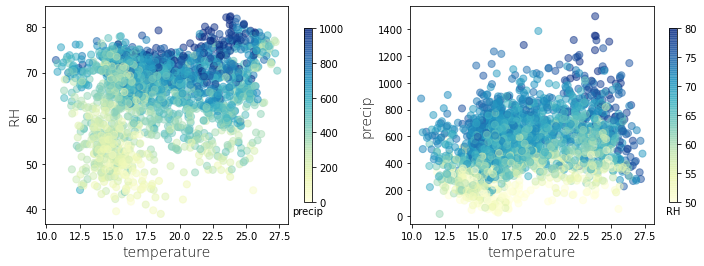

In [224]:
from matplotlib.cm import ScalarMappable

fig = plt.figure(figsize=(12,4))

#cm = plt.cm.get_cmap('YlGnBu')

ax1 = fig.add_subplot(1,2,1)
sc1 = ax1.scatter(temp_all, rh_all, alpha=0.5, s=50, c=precip_all, 
                  cmap=YlGnBu_8.mpl_colormap, vmin=0, vmax=1000)
ax1.set_xlabel('temperature', fontsize=14, fontweight='light')
ax1.set_ylabel('RH', fontsize=14, fontweight='light')
cbar1 = fig.colorbar(sc1, shrink=0.8)
cbar1.ax.set_xlabel('precip')

ax2 = fig.add_subplot(1,2,2)
sc2 = ax2.scatter(temp_all, precip_all, alpha=0.5, s=50, c=rh_all, 
                  cmap=YlGnBu_8.mpl_colormap, vmin=50, vmax=80)
ax2.set_xlabel('temperature', fontsize=14, fontweight='light')
ax2.set_ylabel('precip', fontsize=14, fontweight='light')
cbar2 = fig.colorbar(sc2, shrink=0.8)
cbar2.ax.set_xlabel('RH')


In [134]:
siteyears.head()

,site,year
253,722110,1992
254,722110,1993
255,722110,1994
256,722110,1995
257,722110,1996


In [171]:
df_stations_9110 = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/stations_info_9110.csv', usecols=[0,1,3,4,8,9,10])
df_stations_9110.columns = ['site', 'class', 'station', 'state', 'tzone', 'lat', 'lon']
df_sites = df_stations_9110[df_stations_9110.site.isin(siteyears.site)]
df_sites.head()

,site,class,station,state,tzone,lat,lon
167,722110,1,TAMPA INTERNATIONAL AP,FL,-5,27.967,-82.533
205,722260,1,MONTGOMERY DANNELLY FIELD,AL,-6,32.300,-86.400
231,722350,1,JACKSON INTERNATIONAL AP,MS,-6,32.317,-90.083
239,722400,1,LAKE CHARLES REGIONAL ARPT,LA,-6,30.117,-93.233
243,722410,1,PORT ARTHUR JEFFERSON COUNTY,TX,-6,29.950,-94.017


In [204]:
sites = list(df_sites.site)

temp_sites = [np.nan]*df_sites.shape[0]
rh_sites = [np.nan]*df_sites.shape[0]
precip_sites = [np.nan]*df_sites.shape[0]

for i in np.arange(len(sites)):
    temp = df_temp.loc[:,str(sites[i])].mean()
    rh = df_rh.loc[:,str(sites[i])].mean()
    precip = df_precip.loc[:,str(sites[i])].mean()

    temp_sites[i] = temp
    rh_sites[i] = rh
    precip_sites[i] = precip


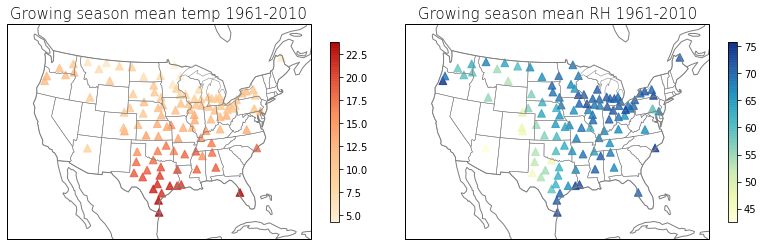

In [239]:
# creating map with weather station sites only
from palettable.colorbrewer.sequential import Purples_9

# sites not filtered
fig = plt.figure(figsize=(12,5))

ax1 = fig.add_subplot(1,2,1, projection=ccrs.AlbersEqualArea(
                          central_latitude=39.5, central_longitude=-98.35))
ax1.set_extent([-123, -72, 19, 53])
mp1 = ax1.scatter(df_sites.lon, df_sites.lat, transform=ccrs.PlateCarree(), 
                  s=60, marker='^', c=temp_sites, cmap=OrRd_6.mpl_colormap, alpha=0.8)
ax1.add_feature(cfeature.BORDERS, edgecolor='grey')
ax1.add_feature(cfeature.COASTLINE, edgecolor='grey')
ax1.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)
ax1.set_title('Growing season mean temp', fontweight='light', fontsize=15)
cbar = fig.colorbar(mp1, shrink=0.5)

ax2 = fig.add_subplot(1,2,2, projection=ccrs.AlbersEqualArea(
                          central_latitude=39.5, central_longitude=-98.35))
ax2.set_extent([-123, -72, 19, 53])
mp2 = ax2.scatter(df_sites.lon, df_sites.lat, transform=ccrs.PlateCarree(), 
                 s=60, marker='^', c=rh_sites, cmap=YlGnBu_8.mpl_colormap, alpha=0.8)
ax2.add_feature(cfeature.BORDERS, edgecolor='grey')
ax2.add_feature(cfeature.COASTLINE, edgecolor='grey')
ax2.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)
ax2.set_title('Growing season mean RH', fontweight='light', fontsize=15)
cbar = fig.colorbar(mp2, shrink=0.5)

fig.subplots_adjust(left=0.05, bottom=0, right=0.95, top=1, wspace=0.05)

### Step 3. Overlay site locations with past yield data
- Main input:
    - /data/NASS_cropdata/**stateID.txt**
    - /data/NASS_cropdata/**countyID.txt**
    - /data/NASS_cropdata/**lat_county.txt**
    - /data/NASS_cropdata/**lon_county.txt**
    - /data/NASS_cropdata/**corn_yield.txt**
    - /data/NASS_cropdata/**corn_area.txt**   
- Main output:
    - /figs/**sites_obsyield.png**

#### 3.1 Reading in USDA NASS yield data

In [194]:
# Reading in state & county id
state_id = pd.read_csv("/home/disk/eos8/ach315/data/NASS_cropdata/stateID.txt", sep="\s+", header=None)
state_id = state_id.transpose()
state_id.columns = ["state_id"]
county_id = pd.read_csv("/home/disk/eos8/ach315/data/NASS_cropdata/countyID.txt", sep="\s+", header=None)
county_id = county_id.transpose()
county_id.columns = ["county_id"]

# Reading in lat & lon information
lat_county = pd.read_csv("/home/disk/eos8/ach315/data/NASS_cropdata/lat_county.txt", sep="\s+", header=None)
lat_county = lat_county.transpose()
lat_county.columns = ["lat"]
lon_county = pd.read_csv("/home/disk/eos8/ach315/data/NASS_cropdata/lon_county.txt", sep="\s+", header=None)
lon_county = lon_county.transpose()
lon_county.columns = ["lon"]

# Reading in maize yield
cornyield = pd.read_csv("/home/disk/eos8/ach315/data/NASS_cropdata/corn_yield.txt", sep="\s+", header=None)
years = np.arange(1910, 2015)
cornyield.columns = years

# Reading in maize area
cornarea = pd.read_csv("/home/disk/eos8/ach315/data/NASS_cropdata/corn_area.txt", sep="\s+", header=None)
years = np.arange(1910, 2015)
cornarea.columns = years
cornarea = cornarea.melt(var_name='year', value_name='area')
cornarea = cornarea.drop(['year'], axis=1)

# concatinating all information and melting dataframe
df = pd.concat([state_id, county_id, lat_county, lon_county, cornyield], axis=1)
df = pd.melt(df, id_vars=['state_id', 'county_id', 'lat', 'lon'], value_name='yield', var_name="year")
df = pd.concat([df, cornarea], axis=1)
print(df.shape)

(326340, 7)


#### 3.2 Subsetting data for year 1961-2010

In [195]:
df_subset = pd.DataFrame()
years = np.arange(1961,2010)

for i in range(len(years)):
    data = df[df['year'] == years[i]]
    df_subset = pd.concat([df_subset, data])

# calculating mean yield & area planted across 1961-1990
df_sitemean = df_subset.groupby(['state_id', 'county_id']).mean()
df_sitemean = df_sitemean.reset_index()

#### 3.3 Visualization

AttributeError: 'DataFrame' object has no attribute 'lon'

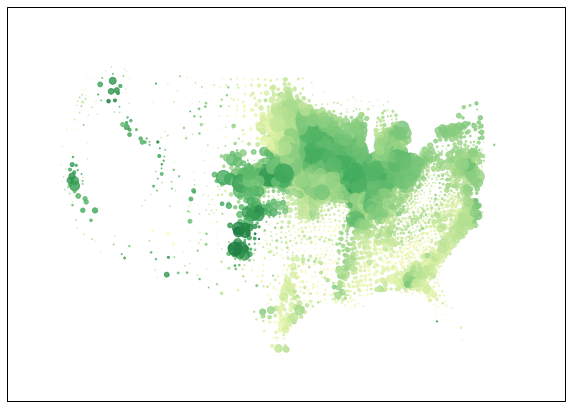

In [198]:
from palettable.colorbrewer.sequential import YlGn_9
from palettable.colorbrewer.sequential import Purples_9

lbperbu = 56
kgperlb = 0.453592
acreperha = 2.47105

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1,1,1, 
                     projection=ccrs.AlbersEqualArea(
                         central_latitude=39.5, central_longitude=-98.35))
ax.set_extent([-123, -72, 19, 53])
ax.scatter(df_sitemean['lon'], df_sitemean['lat'], 
           transform=ccrs.PlateCarree(), 
           c=df_sitemean['yield']*lbperbu*kgperlb/1000, s=df_sitemean['area']/200, 
           cmap=YlGn_9.mpl_colormap, alpha=0.8)

ax.scatter(df_siteyears.lon.astype(float)*-1, df_siteyears.lat.astype(float), 
           transform=ccrs.PlateCarree(), s=100, marker='^',
           c=df_siteyears.years.astype(float), cmap=Purples_9.mpl_colormap, alpha=0.7)
#ax.set_title('Site Locations', fontweight='light', fontsize=18)

ax.add_feature(cfeature.BORDERS, edgecolor='grey')
ax.add_feature(cfeature.COASTLINE, edgecolor='grey')
ax.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)
ax.set_title('average U.S. maize yield (1961-1990)', 
              fontweight='light', fontsize=18)


yield_lim = np.array([[df_sitemean['yield'].min(), df_sitemean['yield'].max()]])
im1 = plt.imshow(yield_lim, cmap=YlGn_9.mpl_colormap)
im1.set_visible("False")
cb_ax1 = fig.add_axes([0.92, 0.25, 0.01, 0.5]) 
cb1 = plt.colorbar(im1, cax=cb_ax1)
cb1.ax.set_ylabel('yield (tons/ha)', fontweight='light', fontsize=15)

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/sites_obsyield.png', format='png', dpi=800)

### Step 4. Climatology

In [14]:
# reading in weather data
df_temp = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/temp_all.csv', index_col= 0)
df_rh = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/rh_all.csv', index_col= 0)
df_precip = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/precip_all.csv', index_col= 0)
df_solrad = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/backup/solrad_all.csv', index_col= 0)
df_solrad = df_solrad.reindex(df_temp.index)

# listing sites to drop from dataset
df_siteinfo = pd.read_csv("/home/disk/eos8/ach315/upscale/weadata/site_info.csv", index_col=0, dtype=str)
sites_AK = df_siteinfo[df_siteinfo.state == 'AK'].site # excluding Alaska
sites_HI = df_siteinfo[df_siteinfo.state == 'HI'].site # excluding Hawaii
sites_PI = df_siteinfo[df_siteinfo.state == 'PI'].site # excluding Guam
drop_sites = list(sites_AK.append(sites_HI).append(sites_PI))

# reforming dataframes
df_temp = df_temp.drop(drop_sites, axis=1)
df_rh = df_rh.drop(drop_sites, axis=1)
df_precip = df_precip.drop(drop_sites, axis=1)
df_solrad = df_solrad.drop(drop_sites, axis=1)
df_siteinfo = df_siteinfo[df_siteinfo.state != 'AK'] # excluding Alaska
df_siteinfo = df_siteinfo[df_siteinfo.state != 'HI'] # excluding Hawaii
df_siteinfo = df_siteinfo[df_siteinfo.state != 'PI'] # excluding GUAM

In [17]:
# putting together xr.Dataset
timepoints = pd.to_datetime(df_temp.index)
sites = df_temp.columns

ds_wea = xr.Dataset({'temp': (['time', 'site'], df_temp),
                     'precip': (['time', 'site'], df_precip),
                     'rh': (['time', 'site'], df_rh),
                     'solrad': (['time', 'site'], df_solrad)},
                    coords= {'time': timepoints, 
                             'site': sites,
                             'lat': df_siteinfo.lat.astype(float), 
                             'lon': df_siteinfo.lon.astype(float)})

ds_wea

<xarray.Dataset>
Dimensions:  (dim_0: 215, site: 215, time: 197310)
Coordinates:
  * time     (time) datetime64[ns] 1961-03-01 1961-03-01T01:00:00 ... 1990-11-30
  * site     (site) object '03103' '03812' '03813' ... '94849' '94860' '94910'
  * dim_0    (dim_0) int64 0 1 2 3 4 5 6 7 8 ... 229 230 231 232 233 234 235 236
    lat      (dim_0) float64 35.08 35.26 32.42 33.22 ... 42.25 45.04 42.53 42.33
    lon      (dim_0) float64 111.4 82.32 83.39 81.58 ... 83.01 83.34 85.31 92.24
Data variables:
    temp     (time, site) float64 nan 12.2 21.7 21.1 18.9 ... nan nan nan 1.7
    precip   (time, site) float64 nan nan 0.0 0.0 0.0 ... nan nan nan nan 0.0
    rh       (time, site) float64 nan 61.14 60.67 67.7 ... nan nan nan 66.34
    solrad   (time, site) float64 nan 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0

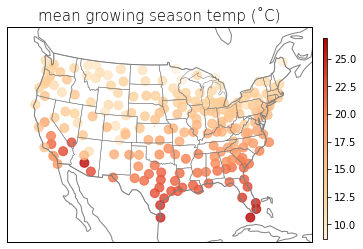

In [25]:
fig = plt.figure(figsize=(12,8))
extent = [-123, -72, 19, 53]

# plotting temperature
ax1 = fig.add_subplot(1,2,1, projection=ccrs.AlbersEqualArea(central_latitude=39.5, central_longitude=-98.35))
ax1.set_extent(extent)
ax1.scatter(ds_wea.lon.astype(float)*-1, ds_wea.lat.astype(float), 
            transform=ccrs.PlateCarree(), c= ds_wea.mean('time').temp, s=80,
            cmap=OrRd_6.mpl_colormap, alpha= 0.8)

ax1.add_feature(cfeature.BORDERS, edgecolor='grey')
ax1.add_feature(cfeature.COASTLINE, edgecolor='grey')
ax1.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)
ax1.set_title('mean growing season temp (˚C)', 
              fontweight='light', fontsize=15)

lim = np.array([[ds_wea.mean('time').temp.min(), ds_wea.mean('time').temp.max()]])
im1 = plt.imshow(lim, cmap=OrRd_6.mpl_colormap)
im1.set_visible("False")
cb_ax1 = fig.add_axes([0.49, 0.32, 0.005, 0.35])
cb1 = plt.colorbar(im1, cax=cb_ax1)


In [44]:
# gathering weather data from all site-years and putting into xarray
years = np.arange(1961,1991)
cols = ['year', 'precip', 'temp', 'rh', 'site', 'lat', 'lon']
df_wea = pd.DataFrame(columns = cols)

for i in years:
    df_year = pd.DataFrame({'year': str(i),
                            'precip': ds_wea.sel(time=slice(str(i)+'-04-01', str(i)+'-10-31')).precip.sum(dim='time'),
                            'temp': ds_wea.sel(time=slice(str(i)+'-04-01', str(i)+'-10-31')).temp.mean(dim='time'),
                            'rh': ds_wea.sel(time=slice(str(i)+'-04-01', str(i)+'-10-31')).rh.mean(dim='time'),
                            'site': ds_wea.site, 'lat': ds_wea.lat, 'lon': ds_wea.lon})
    df_wea = pd.concat([df_wea, df_year])

df_wea = df_wea.drop(['lat', 'lon'], axis=1)

/home/disk/eos8/ach315/anaconda3/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


200506 - still need to plot in precip